In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/balanced_toxic_comments.csv')

In [ ]:
# Move model to GPU if available
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
print(device)

cuda


In [ ]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
column_labels = data.columns.tolist()[2:]
data[column_labels].sum().sort_values()

threat             657
severe_toxic      1962
identity_hate     2016
insult           10748
obscene          11617
toxic            21384
dtype: int64

In [ ]:
# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['comment_text'], data.iloc[:, 2:], test_size=0.25, random_state=42)


# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42)


In [ ]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
	# Initialize empty lists to store tokenized inputs and attention masks
	input_ids = []
	attention_masks = []

	# Iterate through each comment in the 'comments' list
	for comment in comments:

		# Tokenize and encode the comment using the BERT tokenizer
		encoded_dict = tokenizer.encode_plus(
			comment,

			# Add special tokens like [CLS] and [SEP]
			add_special_tokens=True,

			# Truncate or pad the comment to 'max_length'
			max_length=max_length,

			# Pad the comment to 'max_length' with zeros if needed
			pad_to_max_length=True,

			# Return attention mask to mask padded tokens
			return_attention_mask=True,

			# Return PyTorch tensors
			return_tensors='pt'
		)

		# Append the tokenized input and attention mask to their respective lists
		input_ids.append(encoded_dict['input_ids'])
		attention_masks.append(encoded_dict['attention_mask'])

	# Concatenate the tokenized inputs and attention masks into tensors
	input_ids = torch.cat(input_ids, dim=0)
	attention_masks = torch.cat(attention_masks, dim=0)

	# Convert the labels to a PyTorch tensor with the data type float32
	labels = torch.tensor(labels, dtype=torch.float32)

	# Return the tokenized inputs, attention masks, and labels as PyTorch tensors
	return input_ids, attention_masks, labels


In [ ]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=6)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
	tokenizer,
	train_texts,
	train_labels.values
)

# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
	tokenizer,
	test_texts,
	test_labels.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
	tokenizer,
	val_texts,
	val_labels.values
)


print('Training Comments :',train_texts.shape)
print('Input Ids		 :',input_ids.shape)
print('Attention Mask :',attention_masks.shape)
print('Labels		 :',labels.shape)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : (32076,)
Input Ids		 : torch.Size([32076, 128])
Attention Mask : torch.Size([32076, 128])
Labels		 : torch.Size([32076, 6])


In [ ]:
k = 53
print('Training Comments -->>',train_texts.values[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])

Training Comments -->> Wow, crying like a baby to some guy is very mature! 

Seriously, grow up and stop obsessing over me, kid. 70.127.205.86

Input Ids -->>
 tensor([  101, 10166,  1010,  6933,  2066,  1037,  3336,  2000,  2070,  3124,
         2003,  2200,  9677,   999,  5667,  1010,  4982,  2039,  1998,  2644,
        27885,  8583,  7741,  2058,  2033,  1010,  4845,  1012,  3963,  1012,
        13029,  1012, 16327,  1012,  6564,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [ ]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# testing set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# validation set
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101,  3341, 11715,  2152,  2082,  2003,  1996,  3295,  1997,  1996,
        21039,  1997,  1996,  8239,  6071,  3560, 19181,  9247, 24344,  1010,
         1998,  6969,  4682,  2078,  1010,  1996,  8543,  1997,  1996,  8987,
        20228,  9013,  3931,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

In [ ]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Function to Train the Model
def train_model(model, train_loader, optimizer, device, num_epochs):
	# Loop through the specified number of epochs
	for epoch in range(num_epochs):
		# Set the model to training mode
		model.train()
		# Initialize total loss for the current epoch
		total_loss = 0

		# Loop through the batches in the training data
		for batch in train_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			optimizer.zero_grad()

			outputs = model(
				input_ids, attention_mask=attention_mask, labels=labels)
			loss = outputs.loss
			total_loss += loss.item()

			loss.backward()
			optimizer.step()

		model.eval() # Set the model to evaluation mode
		val_loss = 0

		# Disable gradient computation during validation
		with torch.no_grad():
			for batch in val_loader:
				input_ids, attention_mask, labels = [
					t.to(device) for t in batch]

				outputs = model(
					input_ids, attention_mask=attention_mask, labels=labels)
				loss = outputs.loss
				val_loss += loss.item()
		# Print the average loss for the current epoch
		print(
			f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')


# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=5)


Epoch 1, Training Loss: 0.1835802060627153,Validation loss:0.14389006784629255
Epoch 2, Training Loss: 0.12706990695650414,Validation loss:0.14020150868842998
Epoch 3, Training Loss: 0.10373468382668459,Validation loss:0.15559986362322456
Epoch 4, Training Loss: 0.0805221534671182,Validation loss:0.16334124127890737
Epoch 5, Training Loss: 0.061805071835689326,Validation loss:0.18469630516622038


In [ ]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
	model.eval() # Set the model to evaluation mode

	true_labels = []
	predicted_probs = []

	with torch.no_grad():
		for batch in test_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]

			# Get model's predictions
			outputs = model(input_ids, attention_mask=attention_mask)
			# Use sigmoid for multilabel classification
			predicted_probs_batch = torch.sigmoid(outputs.logits)
			predicted_probs.append(predicted_probs_batch.cpu().numpy())

			true_labels_batch = labels.cpu().numpy()
			true_labels.append(true_labels_batch)

	# Combine predictions and labels for evaluation
	true_labels = np.concatenate(true_labels, axis=0)
	predicted_probs = np.concatenate(predicted_probs, axis=0)
	predicted_labels = (predicted_probs > 0.5).astype(
		int) # Apply threshold for binary classification

	# Calculate evaluation metrics
	accuracy = accuracy_score(true_labels, predicted_labels)
	precision = precision_score(true_labels, predicted_labels, average='micro')
	recall = recall_score(true_labels, predicted_labels, average='micro')

	# Print the evaluation metrics
	print(f'Accuracy: {accuracy:.4f}')
	print(f'Precision: {precision:.4f}')
	print(f'Recall: {recall:.4f}')


# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)


Accuracy: 0.6987
Precision: 0.8113
Recall: 0.8718


In [ ]:
# Save the tokenizer and model in the same directory
output_dir = "Saved_model"
# Save model's state dictionary and configuration
model.save_pretrained(output_dir, save_safetensors=False)
# Save tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)
# Load the tokenizer and model from the saved directory
model_name = "Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(
	model_name).to(device)

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
	user_input = [input_text]

	user_encodings = tokenizer(
		user_input, truncation=True, padding=True, return_tensors="pt")

	user_dataset = TensorDataset(
		user_encodings['input_ids'], user_encodings['attention_mask'])

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

	model.eval()
	with torch.no_grad():
		for batch in user_loader:
			input_ids, attention_mask = [t.to(device) for t in batch]
			outputs = model(input_ids, attention_mask=attention_mask)
			logits = outputs.logits
			predictions = torch.sigmoid(logits)

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
	labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
	result = dict(zip(labels_list, predicted_labels[0]))
	return result



In [ ]:
text = "Such an Idiot person"
predict_user_input(model=Bert_Model,
                   tokenizer=Bert_Tokenizer,
                   input_text=text,
                   device=device)

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

In [ ]:
predict_user_input(input_text='How are you?')

{'toxic': 0,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 0,
 'identity_hate': 0}

In [ ]:
predict_user_input(input_text='I hate so much that I want to kill you. You are such a idiot person')

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 1,
 'threat': 1,
 'insult': 1,
 'identity_hate': 0}

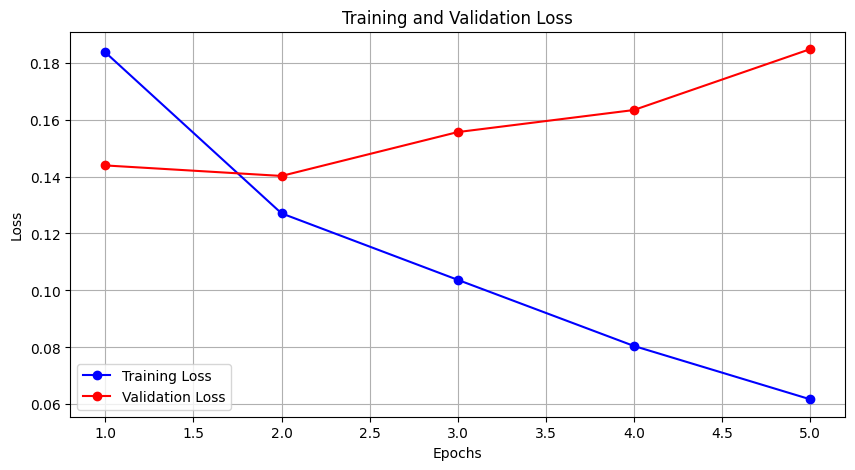

In [ ]:
import matplotlib.pyplot as plt

# Training and validation loss values from the output
train_loss = [0.1835802060627153,0.12706990695650414, 0.10373468382668459, 0.0805221534671182,  0.061805071835689326]
val_loss = [0.14389006784629255,0.14020150868842998,0.15559986362322456,0.16334124127890737,0.18469630516622038]

def plot_loss_curves(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(train_loss, val_loss)
